In [1]:
import pandas as pd
import numpy as np
import os
import pysam
import pickle as pkl
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from Bio import SeqIO
from scipy import stats
from progressbar import ProgressBar
from statsmodels.stats.multitest import multipletests
from roman import toRoman
import itertools
from collections import Counter
import re

In [2]:
rc_sns = {'ytick_color':'k', 'xtick_color':'k', 'text_color':'k', 'font.sans-serif':'DejaVu Sans', 'figure.facecolor':(1,1,1,1)}
sns.set_style(style='ticks', rc=rc_sns)

In [28]:
#path for figures
fig_path = '/home/mathieu/mhenault_landrylab/Publications/lrma/draft/fig/'
tables_path = '/home/mathieu/mhenault_landrylab/Publications/lrma/draft/tables/'

In [98]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
Cross_parents = pd.read_csv('/mnt/HDD3/lrma/private_variants/cross_parents.txt', sep=';', header=None, index_col=0).squeeze()

In [99]:
cross_alias = {'VL3':'CC1',
              'VL4':'CC2',
              'VL5':'CC3',
              'VL1':'BB1',
              'VL2':'BB2',
              'L1':'BC1',
              'L2':'BC2',
              'M1':'BA1',
              'M2':'BA2',
              'H1':'BSc1',
              'H2':'BSc2'}
nano_strains['cross'] = nano_strains['cross'].replace(cross_alias)
cross_order = {j:i for i,j in enumerate(['CC1', 'CC2', 'CC3', 'BB1', 'BB2', 'BC1', 'BC2', 'BA1', 'BA2', 'BSc1', 'BSc2'])}
cross_color = nano_strains.groupby('cross')['cross_color'].apply(lambda x: x.iloc[0]).to_dict()

In [100]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
nano_strains['cross'] = nano_strains['cross'].replace(cross_alias)
cross_parents = pd.read_csv('/mnt/HDD3/lrma/script/cross_parents.csv', sep=',', index_col=0)
cross_color = nano_strains.groupby('cross')['cross_color'].apply(lambda x: x.iloc[0]).to_dict()

parents_background = cross_parents.value_counts(['strain', 'group', 'mat', 'ho', 'ade2']).rename('count').reset_index().set_index('strain')

In [101]:
# dict of parental strains with new cross IDs
for (cross, p) in Cross_parents.items():
    Cross_parents[cross_alias[cross]] = p
Parents_order = dict(zip(['LL2011_004', 'LL2011_009', 'MSH-587-1', 'LL2011_012', 'LL2011_001',
                          'MSH-604', 'UWOPS-91-202', 'LL2012_028', 'LL2012_021',
                          'YPS644', 'YPS744', 'LL2013_040', 'LL2013_054'], range(13)))

parents_group = {'MSH-604':'SpB',
                   'UWOPS-91-202':'SpB',
                   'LL2012_021':'SpB',
                   'LL2012_028':'SpB',
                   'LL2011_004':'SpC',
                   'LL2011_009':'SpC',
                   'MSH-587-1':'SpC',
                   'LL2011_012':'SpC',
                   'LL2011_001':'SpC',
                   'YPS644':'SpA',
                   'YPS744':'SpA',
                   'LL2013_040':'Sc',
                   'LL2013_054':'Sc'}

parents_color = {'MSH-604':'red',
                   'UWOPS-91-202':'red',
                   'LL2012_021':'darkred',
                   'LL2012_028':'darkred',
                   'LL2011_004':'dodgerblue',
                   'LL2011_009':'dodgerblue',
                   'MSH-587-1':'midnightblue',
                   'LL2011_012':'midnightblue',
                   'LL2011_001':'midnightblue',
                   'YPS644':'limegreen',
                   'YPS744':'limegreen',
                   'LL2013_040':'dimgrey',
                   'LL2013_054':'dimgrey'}

mat_alias = {'a': r'$a$', 'alpha':r'$\alpha$'}
group_alias = {'SpA':r'$SpA$', 'SpB':r'$SpB$', 'SpC':r'$SpC$', 'Scer':r'$S.c.$'}

In [4]:
cross_alias = {'VL3':'CC1',
              'VL4':'CC2',
              'VL5':'CC3',
              'VL1':'BB1',
              'VL2':'BB2',
              'L1':'BC1',
              'L2':'BC2',
              'M1':'BA1',
              'M2':'BA2',
              'H1':'BSc1',
              'H2':'BSc2'}
cross_order = {j:i for i,j in enumerate(['CC1', 'CC2', 'CC3', 'BB1', 'BB2', 'BC1', 'BC2', 'BA1', 'BA2', 'BSc1', 'BSc2'])}

In [5]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
nano_strains['cross'] = nano_strains['cross'].replace(cross_alias)
cross_parents = pd.read_csv('/mnt/HDD3/lrma/script/cross_parents.csv', sep=',', index_col=0)
cross_color = nano_strains.groupby('cross')['cross_color'].apply(lambda x: x.iloc[0]).to_dict()

parents_background = cross_parents.value_counts(['strain', 'group', 'mat', 'ho', 'ade2']).rename('count').reset_index().set_index('strain')

In [6]:
Parents_order = dict(zip(['LL2011_004', 'LL2011_009', 'MSH-587-1', 'LL2011_012', 'LL2011_001',
                          'MSH-604', 'UWOPS-91-202', 'LL2012_028', 'LL2012_021',
                          'YPS644', 'YPS744', 'LL2013_040', 'LL2013_054'], range(13)))

parents_group = {'MSH-604':'SpB',
                   'UWOPS-91-202':'SpB',
                   'LL2012_021':'SpB',
                   'LL2012_028':'SpB',
                   'LL2011_004':'SpC',
                   'LL2011_009':'SpC',
                   'MSH-587-1':'SpC',
                   'LL2011_012':'SpC',
                   'LL2011_001':'SpC',
                   'YPS644':'SpA',
                   'YPS744':'SpA',
                   'LL2013_040':'Scer',
                   'LL2013_054':'Scer'}

parents_color = {'MSH-604':'red',
                   'UWOPS-91-202':'red',
                   'LL2012_021':'darkred',
                   'LL2012_028':'darkred',
                   'LL2011_004':'dodgerblue',
                   'LL2011_009':'dodgerblue',
                   'MSH-587-1':'midnightblue',
                   'LL2011_012':'midnightblue',
                   'LL2011_001':'midnightblue',
                   'YPS644':'limegreen',
                   'YPS744':'limegreen',
                   'LL2013_040':'dimgrey',
                   'LL2013_054':'dimgrey'}

mat_alias = {'a': r'$a$', 'alpha':r'$\alpha$'}
group_alias = {'SpA':r'$SpA$', 'SpB':r'$SpB$', 'SpC':r'$SpC$', 'Scer':r'$S.c.$'}

In [ ]:
#split table per subgenome
ns_subg = nano_strains.loc[nano_strains['cross']!='P'].copy()
for c, df in ns_subg.groupby('cross'):
    s1, s2 = cross_parents.loc[c].split(',')
    ns_subg.loc[df.index, 's1'] = s1
    ns_subg.loc[df.index, 's2'] = s2

ns_subg = pd.melt(ns_subg, id_vars=ns_subg.columns[:-2], value_vars=['s1','s2'], value_name='subg', var_name='subg_idx').sort_values(by=['cross','strain','subg_idx'])
ns_subg['s_subg'] = ns_subg.apply(lambda x: f'{x["strain"]}.{x["subg"]}', axis=1)
ns_subg.index = ns_subg['s_subg'].values
# add reference genome for quick mapping 
for sg, df in ns_subg.groupby('subg'):
    if sg in ['LL2013_040','LL2013_054']:
        ns_subg['quick_map'] = '/home/mathieu/mhenault_landrylab/Sequences/ref_genomes/S288C_pacbio/S288c.genome.fa'
    if sg in ['YPS644','YPS744']:
        ns_subg['quick_map'] = '/home/mathieu/mhenault_landrylab/Sequences/ref_genomes/CBS432_pacbio/CBS432.genome.fa'
    else:
        ns_subg['quick_map'] = '/home/mathieu/mhenault_landrylab/Sequences/ref_genomes/YPS138_pacbio/YPS138.genome.fa'
#ns_subg.to_csv('/mnt/HDD3/lrma/script/ns_subg.csv')

In [102]:
# import subgenome metadata table
ns_subg = pd.read_csv('/mnt/HDD3/lrma/script/ns_subg.csv', index_col=0)
ns_subg['cross'] = ns_subg['cross'].replace(cross_alias)
ns_subg['mat'] = parents_background.loc[ns_subg['subg'], 'mat'].values

In [103]:
lines_per_cross = ns_subg.loc[ns_subg['identity_filter']==True].groupby('cross').apply(lambda x: set(x['strain'].values)).to_dict()

# Cross design

## Fig 2A

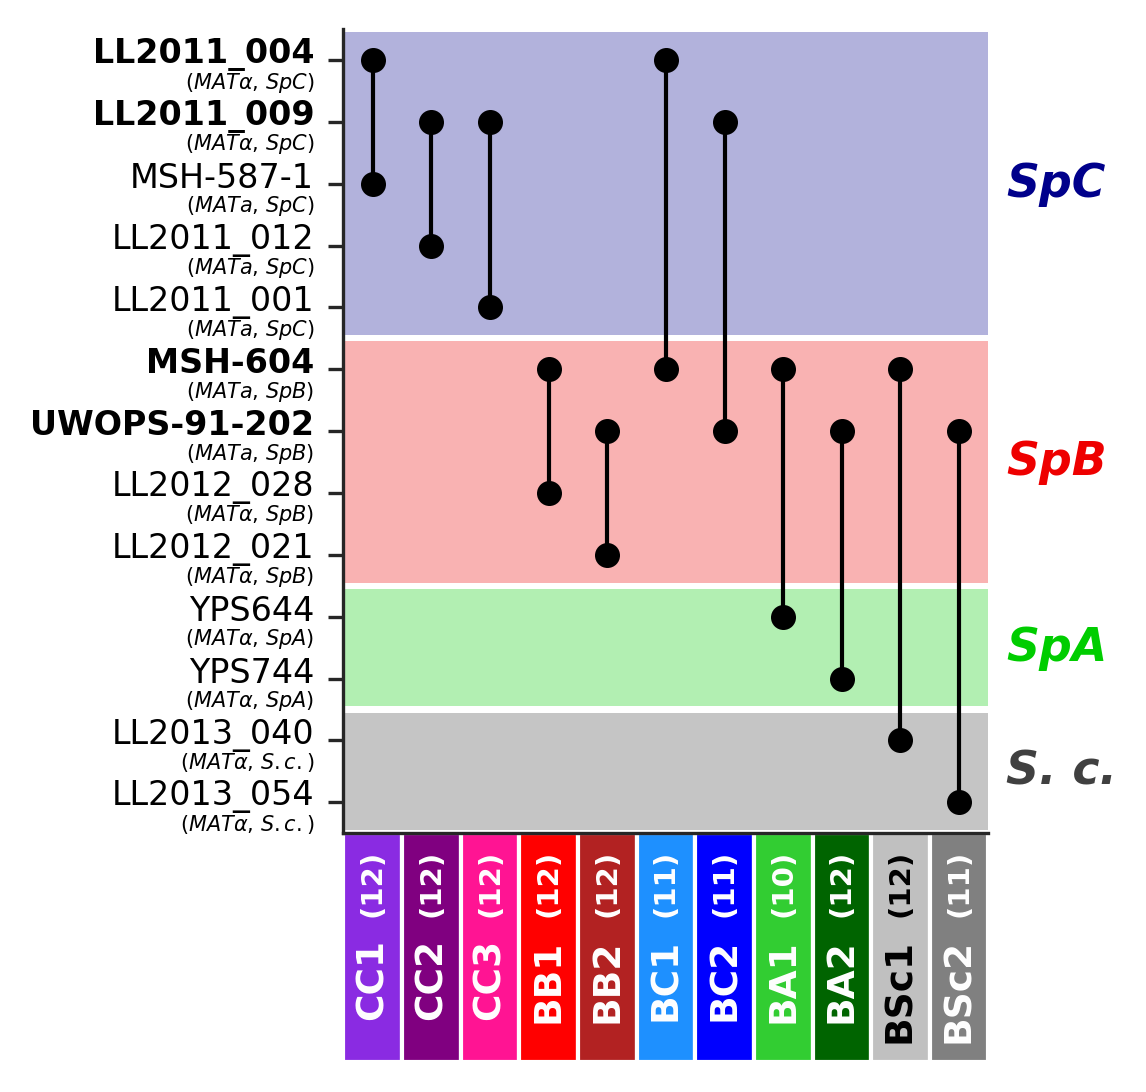

In [104]:
#plot crosses scheme

fig = plt.figure(figsize=[5,4])
gs = plt.GridSpec(ncols=1, nrows=1, left=0.25, right=0.68, top=0.9, bottom=0.23)
ax = fig.add_subplot(gs[0])

#for cross in Cross_parents:
for cross in cross_order:
    sub = cross_parents.loc[cross_parents['cross']==cross].sort_values(by='mat')
    #p1, p2 = Cross_parents[cross].split(',')
    p1, p2 = sub['strain'].values
    
    X = np.repeat(cross_order[cross], 2)
    Y = [Parents_order[p] for p in (p1, p2)]
    
    ax.plot(X, Y, c='k', marker='o', mfc='k', lw=1, ms=5)
    
    fa = FancyArrow(cross_order[cross], 12.5, 0, 3.7, width=1, head_length=0, head_width=0, fc=cross_color[cross], lw=1, ec='w', 
                    clip_on=False, zorder=0)
    ax.add_patch(fa)
    if cross == 'BSc1':
        tc = 'k'
    else:
        tc = 'w'
    ax.text(cross_order[cross], 14.2, cross, size=9, ha='center', va='top', color=tc, rotation=90, fontweight='bold', zorder=1)
    ax.text(cross_order[cross], 13.3, f'({len(lines_per_cross[cross])})', size=7, ha='center', va='center', color=tc, rotation=90, fontweight='bold', zorder=1)
    
for group, (y, dy), fc in zip(['SpC','SpB','SpA','S. c.'], [(0,5), (5,4), (9,2), (11,2)], ['#00008B','#EE0000','#00CD00','0.25']):
    rect_spacing = 0.05
    
    Rect = Rectangle((-0.5, y+rect_spacing-0.5), 11, dy-2*rect_spacing, fc=fc, lw=0, zorder=0, clip_on=False, alpha=0.3)
    ax.add_patch(Rect)
    mid = np.mean([y, dy+y])-0.5
    ax.text(10.8, mid, group, color=fc, size=11, fontweight='semibold', fontstyle='italic',
             va='center', ha='left', clip_on=False, zorder=0)
    

ax.set_ylim(12.5,-0.5)
ax.set_yticks(range(13))
ax.set_yticklabels([])

ax.set_xlim(-0.5, 10.5)
ax.set_xticks([])


for p in Parents_order:
    
    group, mat, c = parents_background.loc[p, ['group', 'mat', 'count']]
    
    if c > 1:
        fw = 'bold'
    else:
        fw = 'normal'
    
    ax.text(-1, Parents_order[p]-0.1, f'{p}', size=8, color='k', ha='right', va='center', weight=fw)
    ax.text(-1, Parents_order[p]+0.35, f'($MAT${mat_alias[mat]}, {group_alias[group]})', size=5, color='k', ha='right', va='center')
    
for i in ['right','top']:
    ax.spines[i].set_visible(False)
    
    
#plt.savefig(f'{fig_path}Fig2A.svg', dpi=300)
plt.show()
plt.close()

# Plot stats from the MA lines assemblies

In [14]:
parent_size = {}
for subg in ns_subg['subg'].unique():
    file = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{subg}.chromosomes.fasta'
    parent_size[subg] = np.sum([len(seq.seq) for seq in SeqIO.parse(file, 'fasta')])

In [39]:
#get statistics on assemblies
assembl_stats = []
for (cross, subg, s), df in ns_subg.loc[ns_subg['identity_filter']].groupby(['cross','subg','s_subg']):
    #cross = cross_alias[cross]
    query = f'/mnt/HDD3/lrma/medaka/{s}/consensus.fasta'
    
    draft = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(query, 'fasta')], axis=1).T.sort_values(by=1, ascending=False)
    Size = draft[1].sum()
    n = draft.shape[0]
    idx, cum = (0,0)
    while cum < Size/2:
        tig, size = draft.loc[idx]
        cum += size
        idx += 1
        
    N50 = size
    assembl_stats.append([cross, cross_order[cross], subg, f'{cross}.{subg}', s, Size, N50, n])

assembl_stats = pd.DataFrame(assembl_stats, columns=['cross','co','subg','cross_subg','s_subg','size','N50','n'])
assembl_stats['strain'] = assembl_stats['s_subg'].apply(lambda x: x.split('.')[0])
assembl_stats['so'] = assembl_stats['strain'].apply(lambda x: int(x[1:]))
assembl_stats.index = assembl_stats['s_subg'].values

In [40]:
for subg, df in assembl_stats.groupby('subg'):
    assembl_stats.loc[df.index, 'size_ratio'] = df['size']/parent_size[subg]*100
assembl_stats['N50_Mb'] = assembl_stats['N50']*1e-6
assembl_stats['N50_log'] = np.log10(assembl_stats['N50'])

In [49]:
assembl_summary = []

for m in ['n', 'N50']:
    for cross, df in assembl_stats.groupby('cross'):
        med = np.median(df[m])
        q005 = np.quantile(df[m], 0.05)
        q095 = np.quantile(df[m], 0.95)
        
        assembl_summary.append([cross, m, med, q005, q095])
        
    
    med = np.median(assembl_stats[m])
    q005 = np.quantile(assembl_stats[m], 0.05)
    q095 = np.quantile(assembl_stats[m], 0.95)
    assembl_summary.append(['global', m, med, q005, q095])
    
assembl_summary = pd.DataFrame(assembl_summary, columns=['cross', 'metric', 'median', 'q005', 'q095'])

## Fig 2C

In [106]:
cross_subgenome_order

1         CC1.MSH-587-1
0        CC1.LL2011_004
3        CC2.LL2011_012
2        CC2.LL2011_009
4        CC3.LL2011_001
5        CC3.LL2011_009
7           BB1.MSH-604
6        BB1.LL2012_028
9      BB2.UWOPS-91-202
8        BB2.LL2012_021
11          BC1.MSH-604
10       BC1.LL2011_004
13     BC2.UWOPS-91-202
12       BC2.LL2011_009
14          BA1.MSH-604
15           BA1.YPS644
16     BA2.UWOPS-91-202
17           BA2.YPS744
19         BSc1.MSH-604
18      BSc1.LL2013_040
21    BSc2.UWOPS-91-202
20      BSc2.LL2013_054
Name: cross_subg, dtype: object

In [116]:
subg_idx.loc[df['subg']]

LL2011_001    1
LL2011_009    0
dtype: int64

In [120]:
cross_subgenome_order = assembl_stats.groupby(['co','subg']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
cross_subgenome_order['mat'] = parents_background.loc[cross_subgenome_order['subg'], 'mat'].values
cross_subgenome_order['subg'] = cross_subgenome_order['s_subg'].apply(lambda x: x.split('.')[1])
for cross, df in cross_subgenome_order.groupby('cross'):
    p1, p2 = Cross_parents[cross].split(',')
    subg_idx = pd.Series({p1:0, p2:1})
    cross_subgenome_order.loc[df.index, 'subg_order'] = subg_idx.loc[df['subg']].values
cross_subgenome_order = cross_subgenome_order.sort_values(by=['co', 'subg_order'])['cross_subg']

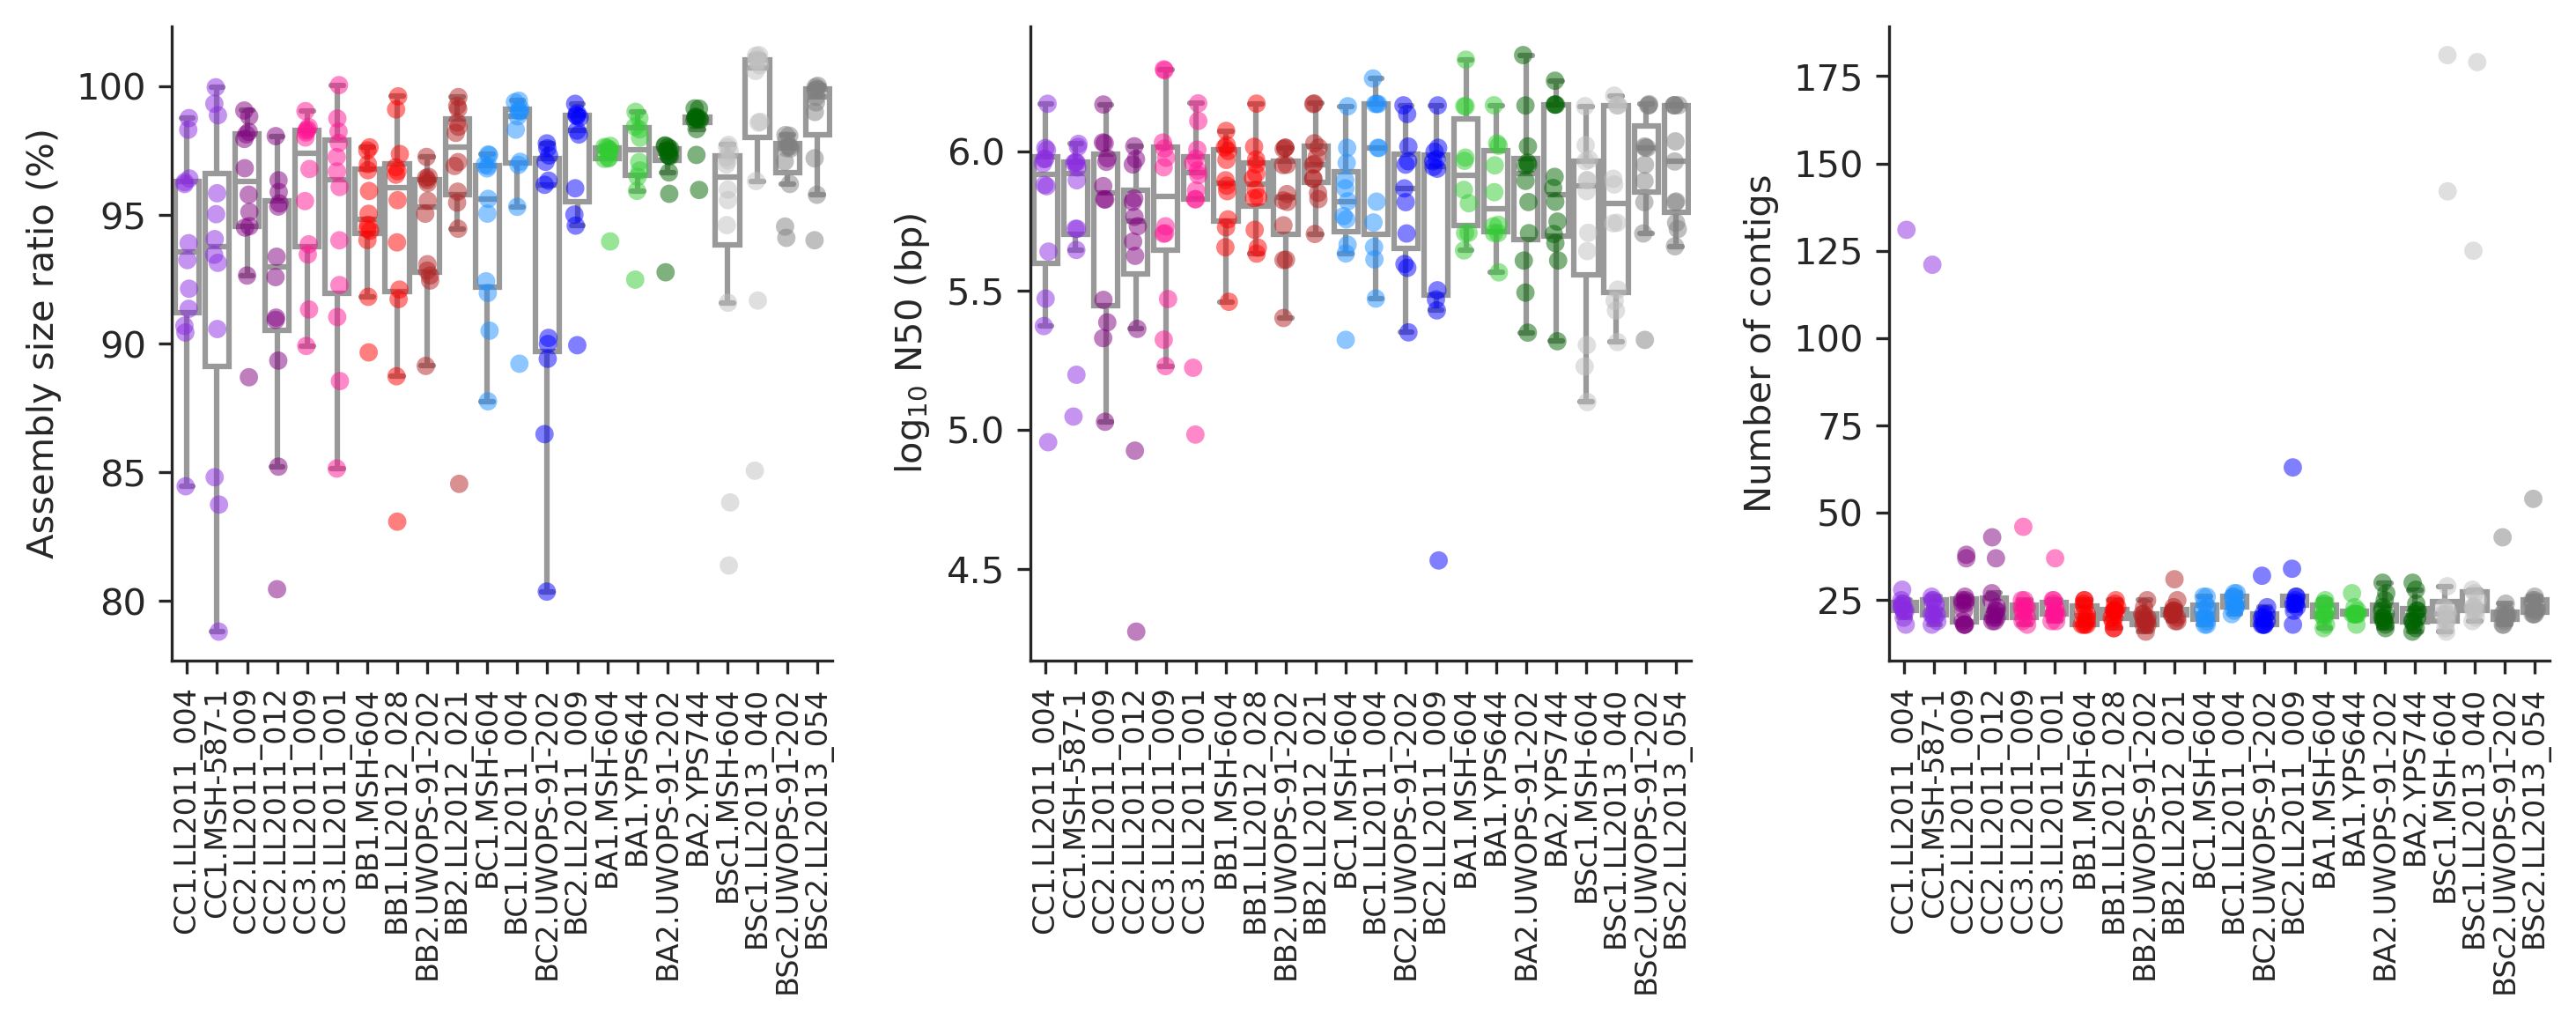

In [122]:
fig, axes = plt.subplots(ncols=3, figsize=[10,4], gridspec_kw=dict(top=0.93, left=0.08, bottom=0.33, right=0.98, wspace=0.3))

for m, m_alias, ax in zip(['size_ratio','N50_log', 'n'],
                          ['Assembly size ratio (%)','log$_{10}$ N50 (bp)' ,'Number of contigs'], axes):

    sns.boxplot(x='cross_subg', y=m, data=assembl_stats, color='w',
                #scale='width',
                fliersize=0,
                order=cross_subgenome_order, ax=ax)
    palette = {cs:cross_color[cs.split('.')[0]] for cs in assembl_stats['cross_subg'].unique()}
    
    sns.stripplot(x='cross_subg', y=m, data=assembl_stats, palette=palette, alpha=0.5, hue='cross_subg',
                order=cross_subgenome_order, ax=ax)
    
    ax.legend_.remove()
    ax.set_xticklabels(cross_subgenome_order, rotation=90, size=8)
    ax.set_xlabel('')
    ax.set_ylabel(m_alias)

sns.despine()

plt.savefig(f'{fig_path}Fig2C.svg', dpi=300)
#plt.show()
#plt.close()

## Supp Table S2

In [42]:
assembl_stats.sort_values(by=['co','so','subg']).to_csv(f'{tables_path}assembly_stats.csv')

In [ ]:
SORT = {}
for s in ['J17','C20']:
    cross = nano_strains.loc[s, 'cross']
    s1, s2 = cross_parents.loc[cross].split(',')

    bam = pysam.AlignmentFile(f'/mnt/HDD3/lrma/minimap_sort/{s}.sort.minimap.bam', 'rb')

    read_len = {}
    query_len = {}
    qual = {}
    secondary = {}
    nm = {}
    aln_pos = {}
    for i in bam:

        name = i.query_name
        read_len[name] = i.infer_read_length()
        query_len[name] = i.infer_query_length()
        secondary[name] = i.is_secondary
        aln_pos[name] = i.reference_start
        if i.is_secondary:
            qual[name] = -1
        else:
            qual[name] = np.mean(i.query_alignment_qualities)

        tags = dict(i.get_tags())
        if 'NM' in tags:
            nm[name] = tags['NM']
        else:
            nm[name] = -1

    tab = pd.read_csv(f'/mnt/HDD3/lrma/private_variants/private_variants_{cross}.tab', sep='\t', header=None,
                     dtype={0:str,1:np.int32,2:str,3:str,4:str,5:str,6:str})
    for gt_col in (5,6):
        tab[gt_col] = np.where(tab[gt_col].isin(['1|1','1/1']), tab[4], tab[3])
    tab.index = tab[1].values-1

    reads = {}
    #s1, s2 = samples
    idx = 0
    with ProgressBar(max_value=tab.shape[0]) as bar:
        for tig, tab_sub in tab.groupby(0):
            # get list of positions on the contig
            loci = bam.pileup(tig)
            #iterate pileups per position
            for pileup in loci:
                i = pileup.reference_pos
                # if position is a snp that allows to discriminate parents, continue
                if i in tab_sub.index:
                    gt1, gt2 = tab_sub.loc[i, [5,6]]

                    for (rid, nt) in zip(pileup.get_query_names(), pileup.get_query_sequences()):
                        # init reads dict
                        if rid not in reads:
                            reads[rid] = {s1:0, s2:0}
                        nt = nt.upper()
                        if nt == gt1:
                            reads[rid][s1] += 1
                        elif nt == gt2:
                            reads[rid][s2] += 1
                    idx += 1
                    bar.update(idx)

    sort = pd.DataFrame(reads).T
    #sort['binom'] = sort.apply(lambda x: stats.binom_test(x[s1], x[s1]+x[s2], 0.5), axis=1)
    sort['sort'] = sort.apply(lambda x : sort_counts(x, s1, s2), axis=1)

    sort['rl'] = pd.Series(read_len).loc[sort.index]
    sort['log_rl'] = np.log10(sort['rl'])
    sort['ql'] = pd.Series(query_len)
    sort['log_ql'] = np.log10(sort['ql'])
    sort['sec'] = pd.Series(secondary)
    sort['nm'] = pd.Series(nm)
    sort['qual'] = pd.Series(qual)
    sort['pos'] = pd.Series(aln_pos)
    sort['log0'] = np.log10(sort[s1]+1)
    sort['log1'] = np.log10(sort[s2]+1)
    sort['%nm'] = sort['nm']/sort['ql']

    #sort['corr_pval'] = multipletests(sort['binom'], alpha=0.05, method='fdr_bh')[0]
    SORT[s] = sort

In [ ]:
def sort_counts(x, s1, s2):
    c1, c2 = x[[s1, s2]]
    if np.max([c1 ,c2]) >= 2:
        if c1 >= 2*c2:
            return s1
        if c2 >= 2*c1:
            return s2
        else:
            return -1
    else:
        return -1

In [ ]:
for gt, df in sort.loc[sort['corr_pval']].groupby('sort'):
    with open(f'/mnt/HDD3/lrma/sort/{s}.{gt}.reads', 'w') as handle:
        handle.write('\n'.join(df.index))

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, gridspec_kw={'height_ratios':(1,4), 'wspace':0.4}, figsize=[8,5])
for (s, sort), ax in zip(SORT.items(), axes.T):
    
    cross = nano_strains.loc[s, 'cross']
    s1, s2 = cross_parents.loc[cross].split(',')
    
    palette={s1:'blue',s2:'red',-1:'0.3'}
    
    sns.scatterplot(data=sort, x=s1, y=s2, hue='sort', edgecolor=(1,1,1,0), ax=ax[1],
                   palette=palette, alpha=0.1, s=10)
    ax[1].set_xlabel(f'snps {s1}')
    ax[1].set_ylabel(f'snps {s2}')
    
    bar = sort.value_counts('sort')
    ax[0].bar(range(3), bar, color=[palette[i] for i in bar.index])
    ax[0].set_xticks(range(3))
    ax[0].set_xticklabels(bar.index)
    ax[0].set_ylabel('sorted reads')
    ax[0].set_title(f'{s} ({cross_alias[cross]})')

sns.despine()
plt.savefig('/mnt/HDD3/lrma/fig/sort_example.png', dpi=300)
plt.show()
plt.close()

### correlate numbers of reads in mappings to sorted subgenomes

In [ ]:
#parse mapping stats
map_sort_stats = {}
for s in nano_strains.loc[nano_strains['cross']!='P'].index:
    with open(f'/mnt/HDD3/lrma/minimap_sort/{s}.sort.minimap.stats') as handle:
        dat = dict([line.split('\t')[1:3] for line in handle.read().splitlines() if line[:2]=='SN'])
        for m,v in dat.items():
            if '.' in v:
                dat[m] = float(v)
            else:
                dat[m] = int(v)
        map_sort_stats[s] = dat

In [ ]:
#parse number of bases
read_lengths = {}
idx = 0
with ProgressBar(max_value=ns_subg.shape[0]) as bar:
    for s in ns_subg.index:
        read_lengths[s]  = np.array([len(seq.seq) for seq in SeqIO.parse(f'/mnt/HDD3/lrma/sort/{s}.reads.fastq', 'fastq')])
        idx += 1
        bar.update(idx)

In [ ]:
#with open('/mnt/HDD3/lrma/sort/rl.pkl', 'wb') as handle:
#    pkl.dump(read_lengths, handle)

In [50]:
with open('/mnt/HDD3/lrma/sort/rl.pkl', 'rb') as handle:
    read_lengths = pkl.load(handle)

In [124]:
#parse read counts from sorted subgenomes
for s in ns_subg.index:
    ns_subg.loc[s, 'bases_subg'] = read_lengths[s].sum()

In [125]:
# parse read counts from whole librarties
for s, df in ns_subg.groupby('strain'):
    stats = pd.read_csv(f'/mnt/HDD3/lrma/seqkit_stats/{s}.stats', engine='python', sep=' +', header=0)
    stats['sum_len'] = stats['sum_len'].apply(lambda x: np.float32(x.replace(',','')))
    ns_subg.loc[df.index, 'bases_tot'] = stats['sum_len'].sum()

## Fig 2B

In [126]:
ns_subg_pivot = ns_subg.loc[ns_subg['identity_filter']==True].sort_values(by='bases_subg').copy()
ns_subg_pivot['bases_ratio'] = ns_subg_pivot['bases_subg']/ns_subg_pivot['bases_tot']*100
ns_subg_pivot = ns_subg_pivot.pivot_table(index=['strain','ploidy','cross'], columns='mat', values='bases_ratio')
ns_subg_pivot['classified'] = ns_subg_pivot['a']+ns_subg_pivot['alpha']

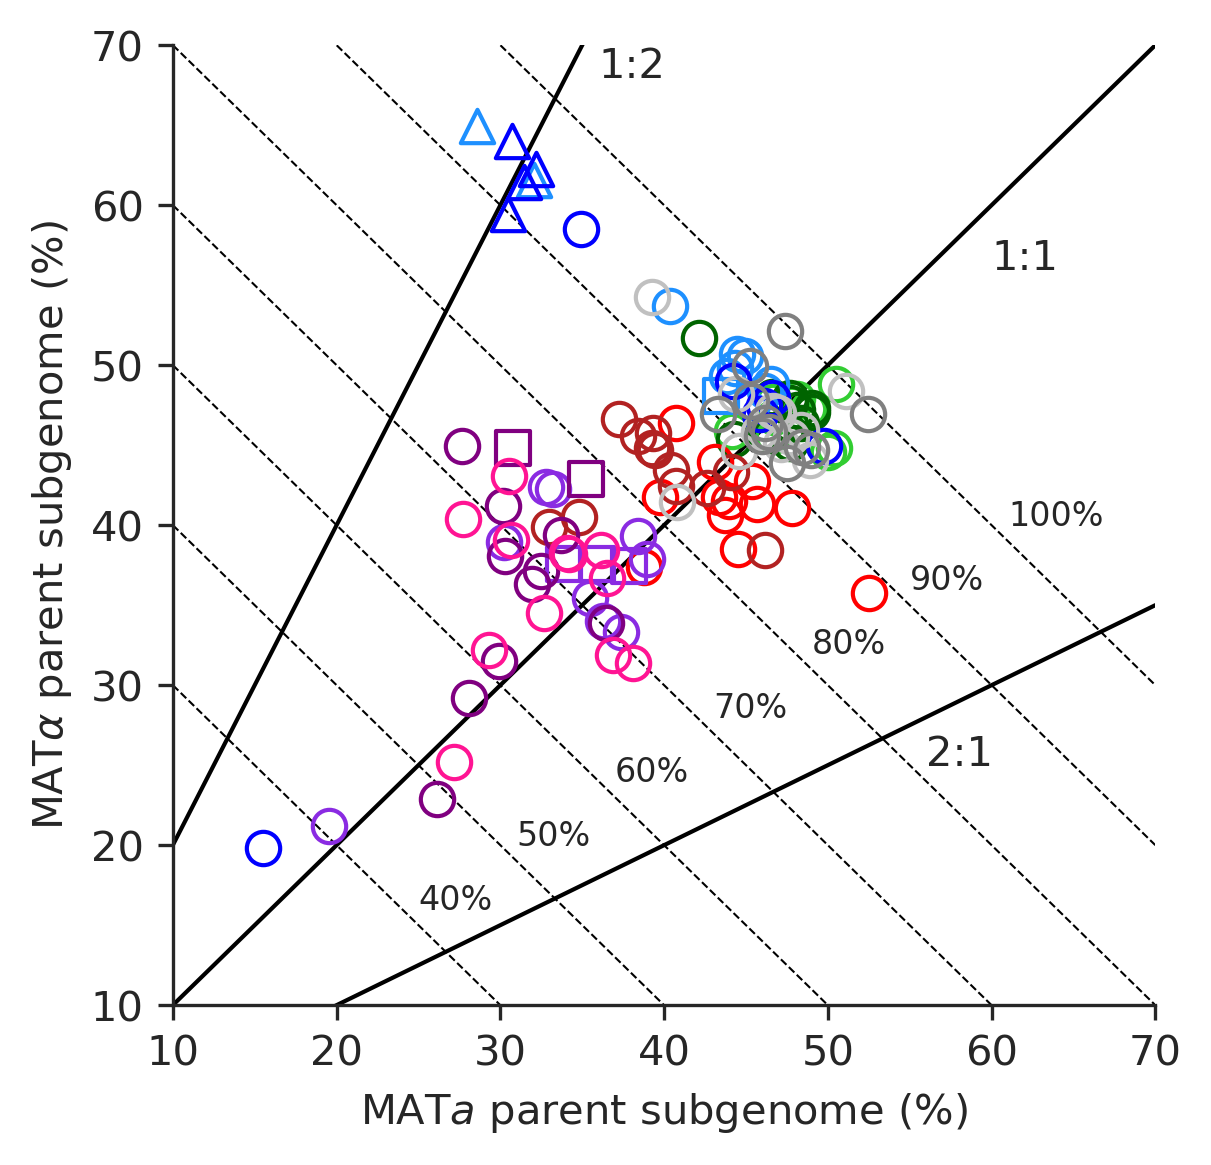

In [127]:
fig, ax = plt.subplots(figsize=[5,4], 
                       gridspec_kw={'right':0.78, 'top':0.95, 'bottom':0.15})
ploidy_symbol = {2:'o', 3:'^', 4:"s"}


for (cross, ploidy), df in ns_subg_pivot.groupby(['cross','ploidy']):
    c = cross_color[cross]
    m = ploidy_symbol[ploidy]
    
    ax.scatter(df['a'], df['alpha'], c='#0f0f0f00', edgecolor=c, marker=m, s=64)
    
xlim = np.array([10, 70])
ax.plot(xlim, xlim, lw=1, c='k', zorder=-1)
ax.text(60, 56, '1:1')
ax.plot(xlim, xlim*2, lw=1, c='k', zorder=-1)
ax.text(36, 68, '1:2')
ax.plot(xlim, xlim/2, lw=1, c='k', zorder=-1)
ax.text(56, 25, '2:1')

for x in np.linspace(40, 100, 7):
    ax.plot(xlim, -xlim+x, c='k', lw=0.5, ls='--', zorder=-1)
    ax.text(3*x/5+1, 2*x/5, f'{x:.0f}%', size=8)

ax.set_xlim(xlim)
ax.set_ylim(15, 70)
ax.set_ylim(xlim)

ax.set_xlabel(f'MAT{mat_alias["a"]} parent subgenome (%)')
ax.set_ylabel(f'MAT{mat_alias["alpha"]} parent subgenome (%)')

# legends
legend_elms1 = [Line2D([0], [0], color=cross_color[cross], lw=2, label=cross) for cross in cross_order]
legend1 = plt.legend(handles=legend_elms1, loc='upper left', bbox_to_anchor=[1.04, 1], handlelength=1.5)
ax.add_artist(legend1)

legend_elms2 = [Line2D([0], [0], color='w', marker=s, mec='k', mfc='#0f0f0f00', ms=8, label=f'{p}n') for p,s in ploidy_symbol.items()]
legend2 = plt.legend(handles=legend_elms2, loc='upper left', bbox_to_anchor=[1.04, 0.25])
ax.add_artist(legend2)

sns.despine()
plt.savefig(f'{fig_path}Fig2B.svg', dpi=300)
#plt.show()
plt.close()

## Fig S3A

In [87]:
ns_subg_reindex = ns_subg.set_index('s_subg')
for m in ['n','size','N50']:
    ns_subg_reindex[m] = assembl_stats[m]
ns_subg_reindex['log_bases_subg'] = np.log10(ns_subg_reindex['bases_subg'])

In [92]:
fig, ax = plt.subplots(figsize=[4,4])
sns.scatterplot(x='log_bases_subg', y='n', hue='cross', palette=cross_color, 
                hue_order=cross_order, data=ns_subg_reindex, ax=ax)
ax.set_xlabel('Bases sorted in subgenome (log$_{10}$)')
ax.set_ylabel('Number of contigs')
ax.legend_.remove()

fig.text(0.02, 0.92, 'A', size=24, fontweight='bold', font='Arial')

sns.despine()
plt.tight_layout()

#plt.show()
plt.savefig(f'{fig_path}Supp_FigS3A.svg', dpi=300)
plt.close()

# Origin of unclassified reads

In [93]:
S_unmapped = ['J44.-1', 'L64.-1', 'B71.-1', 'D93.-1']

In [94]:
read_lengths_unmapped = {}

for s in S_unmapped:
    read_lengths_unmapped[s]  = np.array([len(seq.seq) for seq in SeqIO.parse(f'/mnt/HDD3/lrma/sort/{s}.reads.fastq', 'fastq')])

## Fig S1

In [97]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[8,6], 
                         gridspec_kw={'wspace':1.1, 'hspace':0.7,
                                      'left':0.08, 'bottom':0.08, 'right':0.8, 'top':0.91})

for s, cross, ax_idx in zip(['L64', 'J44', 'D93', 'B71'], ['CC3', 'CC1', 'BC2', 'BA1'],
                    itertools.product(range(2), range(2))):
    
    ax = axes[ax_idx]
    
    for s_subg, unclassified in zip(list(ns_subg.loc[ns_subg['strain']==s].sort_values(by='mat')['s_subg'].values) + [f'{s}.-1'],
                              [False, False, True]):
        
        if unclassified:
            rld = read_lengths_unmapped[f'{s}.-1']
            #label = s_subg.replace('.-1', '.unclassified')
            l = 'Unclassified'
        else:
            rld = read_lengths[s_subg]
            #label = s_subg
            subg = s_subg.split('.')[-1]
            mat = parents_background.loc[subg, 'mat']
            ploidy = ns_subg.loc[s_subg, 'ploidy_subg']
            l = f'{subg}\n(MAT{mat_alias[mat]}, {ploidy:.0f}n)'
            
        label =  f'{l}\ntotal: {rld.sum()*1e-6:.1f} Mb\nmedian: {np.median(rld)*1e-3:.1f} kb'
        
        ax.plot(np.sort(np.log10(rld)), np.linspace(0, 100, rld.shape[0]), label=label)

    ax.legend(fontsize=8, labelspacing=0.9, handlelength=2, loc='center left', bbox_to_anchor=[0.9, 0.5])
    
    ax.set_title(f'{s}\n({cross}, {ns_subg_pivot.loc[s, ["a", "alpha"]].iloc[0].sum():.1f}% classified)')
    ax.set_xticks(range(2, 6))
    ax.set_xlim(1.8,5)
    
    ax.set_xlabel('Read length (log$_{10}$ bp)')
    ax.set_ylabel('% reads')
    
sns.despine()

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Supp_FigS1.{ext}', dpi=300)

#plt.show()
plt.close()

In [ ]:
#Get mapping positions per subgenome
# ref genome used for sort mappings
genome = {}
tig_offsets = []
for seq in SeqIO.parse('/home/mathieu/paradoxus_nanopore/paradoxus4/assemblies/paradoxus4_bc02_smartdenovo_pilon-nanopolish_reordered.fasta', 'fasta'):
    genome[seq.id] = seq
    tig_offsets.append([seq.id, len(seq.seq)])
tig_offsets = pd.DataFrame(tig_offsets)
tig_offsets['off'] = [0] + list(np.cumsum(tig_offsets[1])[:-1])
tig_offsets['end'] = tig_offsets['off']+tig_offsets[1]-1
tig_offsets.index = tig_offsets[0].values

tig_chrom = pd.read_csv('/home/mathieu/paradoxus_nanopore/paradoxus4/barcode02/smartdenovo/mauve/tig_rearrangement.txt', sep='\t', header=None)
for chrom, df in tig_chrom.groupby(0):
    if int(chrom[3:])%2 == 1:
        tig_chrom.loc[df.index, 'color'] = 0
    if int(chrom[3:])%2 == 0:
        tig_chrom.loc[df.index, 'color'] = 1

In [ ]:
# parse read pos

POS_unclassified = []
window = 1e4
for s in ['L64', 'J44', 'D93', 'B71']:
    
    Dat = []
    ploidy = ns_subg.loc[ns_subg['strain']==s, 'ploidy_subg'].sum()
    
    for s_subg in list(ns_subg.loc[ns_subg['strain']==s].sort_values(by='mat')['s_subg'].values) + [f'{s}.-1']:
        dat = pd.read_csv(f'/mnt/HDD3/lrma/sort/{s_subg}.pos.txt', sep='\t', header=None)
        #add offsets
        dat[1] = dat[1] + tig_offsets.loc[dat[0], 'off'].values
        dat = np.histogram(dat[1], bins=np.arange(0, 11.84e6, window))
        dat = pd.Series(dat[0], name=s_subg)
        Dat.append(dat)
    
    Dat = pd.concat(Dat, axis=1).T
    median = np.median(Dat.sum(axis=0))
    Dat = Dat/median*ploidy
    POS_unclassified.append(Dat)

POS_unclassified = pd.concat(POS_unclassified)

## Fig S2

In [ ]:
# heatmap of coverage for examples of lines with high percentage of 
fig = plt.figure(figsize=[7,4])

ax = fig.add_axes([0.22, 0.17, 0.65, 0.8])
cbar_ax = fig.add_axes([0.89, 0.35, 0.03, 0.3])

dat = POS_unclassified
sns.heatmap(dat, cmap='coolwarm', vmin=0, vmax=4, center=1, ax=ax, cbar_ax=cbar_ax)

chrom_color = {0:'0.7', 1:'0.85'}
for (chrom, c), df1 in tig_chrom.groupby([0,'color']):
    df1 = tig_offsets.loc[df1[1].apply(lambda x: f'{x}_pilon')]
    start, length = 1/window * np.array([df1.iloc[0]['off'], df1[1].sum()])
    ar = FancyArrow(start, dat.shape[0]+2, length, 0, width=0.8, head_width=0.8,
                    fc=chrom_color[c], lw=0, length_includes_head=True, clip_on=False, head_length=0)
    ax.add_patch(ar)
    ax.text(start+0.5*length, dat.shape[0]+2, toRoman(int(chrom[3:])), 
            ha='center', va='center', size=7, color='k')

    ax.axvline(start+length, lw=1, color='white')
    
for i in np.arange(0, dat.shape[0]+1, 3):
    ax.axhline(i, lw=1, color='white')

xticks = np.arange(0, dat.shape[1], 1e6/window)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{(i*window/1e6):.0f}' for i in xticks], rotation=0, size=8)
ax.set_xlabel('Position (Mb)')
ax.set_yticks(np.array(range(dat.shape[0]))+0.5)
ax.set_yticklabels([i.replace('.-1', '.unclassified') for i in dat.index], size=8)

cbar_ax.set_ylabel('Relative depth of coverage (X)')

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Supp_FigS2.{ext}', dpi=300)

#plt.show()
plt.close()

In [ ]:
# all coverage heatmaps 

In [ ]:
fig, ax = plt.subplots()
dat = POS.loc[ns_subg.sort_values(by=['cross','strain','subg_idx']).index]

sns.heatmap(dat, cmap='coolwarm', vmin=0, vmax=4, center=1)

for (chrom, c), df1 in tig_chrom.groupby([0,'color']):
    df1 = tig_offsets.loc[df1[1].apply(lambda x: f'{x}_pilon')]
    start, length = 1/window * np.array([df1.iloc[0]['off'], df1[1].sum()])
    ar = FancyArrow(start, df.shape[0]+2, length, 0, width=0.8, head_width=0.8,
                    fc=c, lw=0, length_includes_head=True, clip_on=False, head_length=0)
    ax.add_patch(ar)
    ax.text(start+0.5*length, df.shape[0]+2, toRoman(int(chrom[3:])), 
            ha='center', va='center', size=7, color='w')

    ax.axvline(start+length, lw=1, color='white')
    for i in np.arange(0, df.shape[0]+1, 2):
        ax.axhline(i, lw=1, color='white')

#ax.set_title(cross_alias[cross])
ax.set_xticks(np.arange(0,120,10))
ax.set_xticklabels([f'{i}M' for i in np.arange(0,12,1)], rotation=0, size=8)
#ax.set_yticks(range(df.shape[0]))
#ax.set_yticklabels(df.index, size=8)
ax.set_yticklabels([])

plt.tight_layout()
#plt.savefig(f'/mnt/HDD3/lrma/fig/hm_cov_subgenome_{cross_alias[cross]}.png', dpi=300)
plt.show()
plt.close()

In [ ]:
os.stat(f'/mnt/HDD3/lrma/wtdbg2/{s}/{s}.cns.fa').st_size

In [ ]:
query = '/mnt/HDD3/lrma/medaka/A30.LL2011_004/consensus.fasta'
ref = '/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/LL2011_004.chromosomes.fasta'

# get filesize
if os.stat(query).st_size > 0:
    tig_off = {}
    for i, file in enumerate([ref, query]):
        tig_off[i] = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(file, 'fasta')], axis=1).T
        tig_off[i].index = tig_off[i][0].values
        # if ref, sort now. if query, sort after
        if i==0:
            tig_off[i][2] = np.concatenate([np.array([0]), np.cumsum(tig_off[i][1].values)[:-1]])

In [ ]:
        coords = pd.read_csv(coords, sep='\t', 
                             #skiprows=4,
                             header=None)
        # remove hits shorter than 10kb
        coords = coords.loc[(coords[4]>1e4) & (coords[5]>1e4)]

        if coords.shape[0] > 0:
            for j in (0,1):
                coords[j] += tig_off[0].loc[coords[9], 2].values
            order_query = coords.groupby(10).apply(lambda x: np.mean(x.sort_values(by=5, ascending=False).iloc[0, [0,1]])).sort_values()
            tig_off[1] = tig_off[1].loc[order_query.index]
            tig_off[1][2] = np.concatenate([np.array([0]), np.cumsum(tig_off[1][1].values)[:-1]])
            for j in (2,3):
                coords[j] += tig_off[1].loc[coords[10], 2].values

            # flip query contigs
            for tig, df in coords.groupby(10):
                if (df[8]*df[5]).mean() < 0:
                    coords_copy = df[[2,3]].copy()
                    midpoint = np.mean([(coords_copy[3].min(), coords_copy[2].max())])
                    coords.loc[df.index, [2,3]] = -1*(coords_copy-midpoint)+midpoint
                    coords.loc[df.index, 8] *= -1

            for i in coords.index:
                if coords.loc[i, 8] == -1:
                    c = 'red'
                else:
                    c = 'black'

                ax.plot(coords.loc[i, [0,1]], coords.loc[i, [2,3]], c=c, lw=2, alpha=0.5)


            if decorate in ('ref','both'):
                for tig in tig_off[0].index:
                    pos = tig_off[0].loc[tig, 2]
                    ax.axvline(pos, lw=0.5, ls=':', color='0.5')
                    if tig_off[0].loc[tig, 1] > 1e5:
                        ax.text(pos, 0, tig, ha='left', va='top', size=7, rotation=90)
            if decorate == 'both':
                for tig in tig_off[1].index:
                    pos = tig_off[1].loc[tig, 2]
                    ax.axhline(pos, lw=0.5, ls=':', color='0.5')
                    if tig_off[1].loc[tig, 1] > 1e5:
                        ax.text(0, pos, tig, ha='right', va='bottom', size=7)
                        
            if return_tig_off:
                return tig_off

In [ ]:
def plot_mummer(s, ref, query, coords, ax, decorate=False, return_tig_off=False):  

    # get filesize
    if os.stat(query).st_size > 0:
        tig_off = {}
        for i, file in enumerate([ref, query]):
            tig_off[i] = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(file, 'fasta')], axis=1).T
            tig_off[i].index = tig_off[i][0].values
            # if ref, sort now. if query, sort after
            if i==0:
                tig_off[i][2] = np.concatenate([np.array([0]), np.cumsum(tig_off[i][1].values)[:-1]])

        coords = pd.read_csv(coords, sep='\t', 
                             #skiprows=4,
                             header=None)
        # remove hits shorter than 10kb
        coords = coords.loc[(coords[4]>1e4) & (coords[5]>1e4)]

        if coords.shape[0] > 0:
            for j in (0,1):
                coords[j] += tig_off[0].loc[coords[9], 2].values
            order_query = coords.groupby(10).apply(lambda x: np.mean(x.sort_values(by=5, ascending=False).iloc[0, [0,1]])).sort_values()
            tig_off[1] = tig_off[1].loc[order_query.index]
            tig_off[1][2] = np.concatenate([np.array([0]), np.cumsum(tig_off[1][1].values)[:-1]])
            for j in (2,3):
                coords[j] += tig_off[1].loc[coords[10], 2].values

            # flip query contigs
            for tig, df in coords.groupby(10):
                if (df[8]*df[5]).mean() < 0:
                    coords_copy = df[[2,3]].copy()
                    midpoint = np.mean([(coords_copy[3].min(), coords_copy[2].max())])
                    coords.loc[df.index, [2,3]] = -1*(coords_copy-midpoint)+midpoint
                    coords.loc[df.index, 8] *= -1

            for i in coords.index:
                if coords.loc[i, 8] == -1:
                    c = 'red'
                else:
                    c = 'black'

                ax.plot(coords.loc[i, [0,1]], coords.loc[i, [2,3]], c=c, lw=1, alpha=0.5)


            if decorate in ('ref','both'):
                for tig in tig_off[0].index:
                    pos = tig_off[0].loc[tig, 2]
                    ax.axvline(pos, lw=1, ls=':', color='blue', zorder=0)
                    if tig_off[0].loc[tig, 1] > 1e5:
                        ax.text(pos, 0, tig, c='blue', ha='left', va='top', size=7, rotation=90)
            if decorate == 'both':
                for tig in tig_off[1].index:
                    pos = tig_off[1].loc[tig, 2]
                    ax.axhline(pos, lw=1, ls=':', color='blue', zorder=0)
                    if tig_off[1].loc[tig, 1] > 1e5:
                        ax.text(0, pos, tig, c='blue', ha='right', va='bottom', size=7)
                        
            if return_tig_off:
                return tig_off

In [ ]:
#quick alignment of draft assemblies

for (cross, subg), df in ns_subg.loc[ns_subg['identity_filter']].groupby(['cross','subg']):
    
    fig, ax = plt.subplots(figsize=[7,7])
    
    decorate = True
    
    for (s,r), df1 in df.groupby(['s_subg','subg']):
        ref = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{r}.chromosomes.fasta'
        qry = f'/mnt/HDD3/lrma/chroder/{s}.chroder.qry.fasta'
        coords = f'/mnt/HDD3/lrma/chroder/{s}.chroder.coords'
        plot_mummer(s, ref, qry, coords, ax, decorate=decorate)
        decorate = False

    ax.set_title(f'{cross} {subg}')
    ax.set_xlabel('reference genome')
    ax.set_ylabel('draft genome')
    
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'/mnt/HDD3/lrma/fig/draft_assemblies_{cross}_{subg}.png', dpi=300)
    #plt.show()
    plt.close()

In [ ]:
plt.scatter(range(10), range(10), color='red')
plt.savefig('/mnt/HDD1/Dropbox/temp_sync/range10.png', dpi=600)
plt.close()

In [ ]:
ns_subg.loc[ns_subg['identity_filter']].shape

In [ ]:
#quick alignment of draft assemblies, per-line

idx_bar = 0
with ProgressBar(max_value=254) as bar:
    for (s, cross, ref), df in ns_subg.loc[ns_subg['identity_filter']].groupby(['s_subg','cross','ref_chroder']):
    #if s == 'B7.MSH-604':
        qry = f'/mnt/HDD3/lrma/chroder/{s}.chroder.qry.fasta'
        coords = f'/mnt/HDD3/lrma/chroder/{s}.chroder.fil.coords'

        if os.path.exists(qry) and os.path.exists(coords):

            fig, ax = plt.subplots(figsize=[7,7])
            plot_mummer(s, ref, qry, coords, ax, decorate='both')

            ax.set_title(f'{s}')
            ax.set_xlabel(ref.split('/')[-1])
            ax.set_ylabel(s)
            
            ax.set_xticks(np.arange(0, 1.2e7, 1e6))
            ax.xaxis.set_minor_locator(MultipleLocator(1e5))
            #ax.yaxis.set_minor_locator(MultipleLocator(1e5))
            ax.grid(axis='x', which='minor', lw=0.3)
            ax.grid(axis='x', which='major', lw=0.7)
            #ax.grid(axis='y', which='minor', lw=0.3)
            #ax.grid(axis='y', which='major', lw=0.7)
            

            sns.despine()
            plt.tight_layout()
            plt.savefig(f'/mnt/HDD3/lrma/fig/draft_assemblies/draft_assembly_{cross}_{s}.png', dpi=300)
            #plt.savefig(f'/mnt/HDD1/Dropbox/temp_sync/draft_assembly_{cross}_{s}.png', dpi=500)
            plt.close()
            
        idx_bar += 1
        bar.update(idx_bar)

# dnadiff analysis

In [ ]:
cross_color = ns_subg.groupby('cross').apply(lambda x: x.iloc[0]['cross_color']).to_dict()
subg_order = ['MSH-604','UWOPS-91-202','LL2012_021','LL2012_028',
             'LL2011_004','LL2011_009','MSH-587-1','LL2011_012','LL2011_001',
             'YPS644', 'YPS744', 'LL2013_040', 'LL2013_054']

In [ ]:
# parse mummer dnadiff report
dnadiff = []
for s in ns_subg.loc[ns_subg['identity_filter']].index:
    dat = pd.read_csv(f'/mnt/HDD3/lrma/medaka/{s}/{s}.report', skiprows=4, header=None, sep=' +', comment='[').dropna(how='all')
    dat = dat.drop(range(37,50))
    dat = dat.drop(range(59,68))
    dat.columns = ['feat', '', 'value']
    dat['s_subg'] = s
    dnadiff.append(dat.iloc[:, [0,2,3]])
dnadiff = pd.concat(dnadiff).reset_index()
dnadiff = pd.concat([dnadiff, dnadiff['value'].apply(lambda x: pd.Series(re.match('(\d+)(?:\((\d+\.\d+)%\))*', x).groups(), index=['count','perc']))], axis=1)
dnadiff['count'] = dnadiff['count'].astype(int)
dnadiff['perc'] = dnadiff['perc'].astype(float)
for c in ['strain', 'subg', 'cross', 'batch']:
    dnadiff[c] = ns_subg.loc[dnadiff['s_subg'], c].values

subst_dict = {'AT':'A_T',
             'AC':'A_C',
             'AG':'A_G',
             'CA':'C_A',
             'CT':'C_T',
             'CG':'C_G',
             'TA':'A_T',
             'TC':'A_G',
             'TG':'A_C',
             'GA':'C_T',
             'GT':'C_A',
             'GC':'C_G'}
indel_dict = {'.A':'.A',
             '.T':'.A',
             '.C':'.C',
             '.G':'.C',
             'A.':'A.',
             'T.':'A.',
             'C.':'C.',
             'G.':'C.'}
for f, df in dnadiff.groupby('feat'):
    if len(f) == 2:
        if re.match('[ATCG]\.', f) or re.match('\.[ATCG]', f):
            dnadiff.loc[df.index, 'feat_type'] = 'indel'
            dnadiff.loc[df.index, 'indel_type'] = indel_dict[f]
        if re.match('[ATCG]{2}', f):
            dnadiff.loc[df.index, 'feat_type'] = 'subst'
            dnadiff.loc[df.index, 'subst_type'] = subst_dict[f]

In [ ]:
data = dnadiff.loc[dnadiff['feat_type']=='subst']
fig, ax = plt.subplots(figsize=[12,5])
sns.boxplot(x='cross', y='count', hue='subst_type', order=cross_order,
            data=data)
ax.set_yscale('log')
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/subst_medaka_cross.png', dpi=300)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=[9,4])
sns.boxplot(x='batch', y='count', hue='subst_type', order=[f'batch{i}' for i in range(1,8)],
            data=data)
ax.set_yscale('log')
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/subst_medaka_batch.png', dpi=300)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=[12,5])
sns.boxplot(x='subg', y='count', hue='subst_type', order=subg_order,
            data=data)
ax.set_yscale('log')
ax.set_xticklabels(subg_order, rotation=30)
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/subst_medaka_subg.png', dpi=300)
plt.show()
plt.close()

In [ ]:
data = dnadiff.loc[dnadiff['feat_type']=='indel']
fig, ax = plt.subplots(figsize=[12,5])
sns.boxplot(x='cross', y='count', hue='indel_type', order=cross_order,
            data=data)
ax.set_yscale('log')
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/indel_medaka_cross.png', dpi=300)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=[9,4])
sns.boxplot(x='batch', y='count', hue='indel_type', order=[f'batch{i}' for i in range(1,8)],
            data=data)
ax.set_yscale('log')
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/indel_medaka_batch.png', dpi=300)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=[12,5])
sns.boxplot(x='subg', y='count', hue='indel_type', order=subg_order,
            data=data)
ax.set_yscale('log')
ax.set_xticklabels(subg_order, rotation=30)
ax.legend(loc=6, frameon=False, bbox_to_anchor=[1,0.5])

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/indel_medaka_subg.png', dpi=300)
plt.show()
plt.close()

In [ ]:
SYRI['<DEL>']

In [ ]:
SYRI = []

for s in ns_subg.loc[ns_subg['identity_filter']].index:

    vcf_path = f'/mnt/HDD3/lrma/syri/{s}/{s}.syri.vcf'
    if os.stat(vcf_path).st_size > 0:
        vcf = pd.read_csv(vcf_path, comment='#', header=None, sep='\t')
        vcf = vcf.rename(columns={4:'4'})
        vcf = vcf.value_counts('4').reset_index()
        vcf.columns = ['sv_type','count']
        vcf['s_subg'] = s
        SYRI.append(vcf)

SYRI = pd.concat(SYRI).reset_index(drop=True)
SYRI['sv_type'] = SYRI['sv_type'].apply(lambda x: x.strip('<>'))
for c in ['strain', 'subg', 'cross', 'batch']:
    SYRI[c] = ns_subg.loc[SYRI['s_subg'], c].values

In [ ]:
data = SYRI.loc[SYRI['sv_type'].isin(['DUP','INVDP','TRANS','INVTR'])]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[9,6])

for (ax_y, ax_x), (sv, df) in zip(itertools.product(range(2), range(2)), data.groupby('sv_type')):
    ax = axes[ax_y, ax_x]
    sns.boxplot(x='cross', y='count', data=df, ax=ax, palette=cross_color, order=cross_order)
    ax.set_title(sv)
    
sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/syri_sv_counts.png', dpi=300)
plt.close()

In [ ]:
r = 'LL2012_028'
s = 'I8.LL2012_028'

ref = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{r}.chromosomes.fasta'
qry = f'/mnt/HDD3/lrma/chroder/{s}.chroder.qry.fasta'
coords = f'/mnt/HDD3/lrma/chroder/{s}.chroder.fil.coords'

#vcf = pd.read_csv('/mnt/HDD3/lrma/syri/testsyri.vcf', comment='#', header=None, sep='\t')
vcf = pd.read_csv('/mnt/HDD3/lrma/syri/I8.LL2012_028.syri.vcf', comment='#', header=None, sep='\t')
vcf = pd.concat([vcf, vcf[7].apply(lambda x: pd.Series(dict([i.split('=') for i in x.split(';')])))], axis=1)
vcf = vcf.replace('.', np.nan).astype({'END':np.float32,'StartB':np.float32,'EndB':np.float32})
# only keep vcf entries for which a chrB is defined 
vcf = vcf.loc[vcf['ChrB'].apply(lambda x: type(x)==str)]
for col in [1, 'END']:
    vcf[col] = vcf[col] + tig_off[0].loc[vcf[0], 2].values
for col in ['StartB', 'EndB']:
    vcf[col] = vcf[col] + tig_off[1].loc[vcf['ChrB'], 2].values

fig, ax = plt.subplots(figsize=[7,6])
tig_off = plot_mummer(s, ref, qry, coords, ax, decorate='both', return_tig_off=True)
    
sv_color = dict(zip(['<DUP>','<INVDP>','<TRANS>','<INVTR>'], [cm.tab10(i) for i in range(4)]))
    
for sv, df in vcf.loc[vcf[4].isin(['<DUP>','<INVDP>','<TRANS>','<INVTR>'])].groupby(4):
    
    
    for i in df.index:
        x = vcf.loc[i, [1,'END']].astype(float)
        y = vcf.loc[i, ['StartB','EndB']].astype(float)
        ax.plot(x, y, lw=1, marker='o', ms=4, color=sv_color[sv])

ax.set_xlabel(ref.split('/')[-1])
ax.set_ylabel(s)
ax.legend(handles=[Line2D([0], [0], color='w', marker='s', mfc=c, label=l.strip('<>')) for l,c in sv_color.items()],
         loc=6, bbox_to_anchor=[1,0.5], frameon=False)

sns.despine()
plt.tight_layout()
plt.savefig('/mnt/HDD3/lrma/fig/syri_I8.LL2012_028.dotplot.png', dpi=300)
plt.show()
plt.close()

In [ ]:
set(vcf[4])

# analysis of structural variants from draft assemblies

In [ ]:
NEW_ASSEMBLIES = {}
tig_order = {}
cum_len = {}
for s in set(ns_subg['subg'].values):
    NEW_ASSEMBLIES[s] = {}
    tig_order[s] = []
    cl = []
    path = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{s}.chromosomes.fasta'
    
    with open(path) as fi:
        for seq in SeqIO.parse(fi, 'fasta'):
            NEW_ASSEMBLIES[s][seq.id] = seq
            tig_order[s].append(seq.id)
            cl.append(len(seq.seq))
    
    cl = pd.Series([0]+list(np.cumsum(cl)[:-1]), index=tig_order[s])
    cum_len[s] = cl

In [ ]:
SV_draft = []
for s in ns_subg.index:
    df = pd.read_csv(f'/mnt/HDD3/lrma/svim-asm_draft/{s}/variants.vcf', skiprows=34, sep='\t')
    if df.shape[0] > 0:
        df['strain'] = s
        SV_draft.append(df)
SV_draft = pd.concat(SV_draft).reset_index(drop=True)
SV_draft = pd.concat([SV_draft, SV_draft['INFO'].apply(lambda x: pd.Series(dict([i.split('=') for i in x.split(';')])))], axis=1)
SV_draft = SV_draft.astype({'SVLEN':np.float32})
col1 = list(assembl_stats.columns)
col2 = [i for i in ns_subg if i not in col1]
for s, df in SV_draft.groupby('strain'):
    if s in assembl_stats.index:
        for c in col1:
            SV_draft.loc[df.index, c] = assembl_stats.loc[s, c]
    for c in col2:
        SV_draft.loc[df.index, c] = ns_subg.loc[s, c]

In [ ]:
#add absolute coordinates to SVs
for (subg,chrom), df in SV_draft.groupby(['subg','#CHROM']):
    SV_draft.loc[df.index, 'pos'] = df['POS'] + cum_len[subg][chrom]

In [ ]:
#classify breakpoints as private
SV_draft.loc[SV_draft['identity_filter'], 'min_dist'] = 12e6
for (svt,subg,chrom), df in SV_draft.loc[SV_draft['identity_filter']].groupby(['SVTYPE','subg','#CHROM']):
    
    for i,j in itertools.combinations(df.index, 2):
        #ensure that comparison is between different strains
        if df.loc[i,'s_subg'] != df.loc[j,'s_subg']:
            d = abs(df.loc[i,'POS'] - df.loc[j,'POS'])
            if d < SV_draft.loc[i, 'min_dist']:
                SV_draft.loc[i, 'min_dist'] = d
            if d < SV_draft.loc[j, 'min_dist']:
                SV_draft.loc[j, 'min_dist'] = d
SV_draft['log_min_dist'] = np.log10(SV_draft['min_dist']+1)

In [ ]:
sns.histplot(x='log_min_dist', hue='subg', bins=100, data=SV_draft.loc[SV_draft['SVTYPE']=='BND'])

plt.show()
plt.close()

In [ ]:
hist_bp = {}
bins = np.arange(0,12e6,1e4)
for subg, df in SV_draft.loc[SV_draft['SVTYPE']=='BND'].groupby('subg'):
    hist_bp[subg] = []
    for s, df1 in df.groupby('s_subg'):
        h = np.histogram(df1['pos'], bins=bins)
        h = pd.Series(h[0], name=s)
        hist_bp[subg].append(h)
    hist_bp[subg] = pd.concat(hist_bp[subg], axis=1).T
    

In [ ]:
for subg, df in hist_bp.items():
    fig, ax = plt.subplots(figsize=[10,3])
    sns.heatmap(df, cmap='Blues', ax=ax)
    ax.set_title(subg)
    plt.show()
    plt.close()

In [ ]:
sns.histplot(x='SVLEN', hue='subg', data=SV_draft.loc[SV_draft['SVTYPE']=='INS'], bins=100)
plt.show()
plt.close()